In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

def lin_regplot(X, y, model):
    plt.scatter(X, y, c='steelblue', edgecolor='white', s=70)
    plt.plot(X, model.predict(X), color='black', lw=2)    
    return 

In [5]:
df = pd.read_csv('housing.data', header=None,sep='\s+')
df.columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
              'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
              'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
X = df[['LSTAT']].values
y = df['MEDV'].values

二元決策樹也可以用來做線性回歸，驚不驚喜，意不意外?在這裡我們藉由最大化"資訊增益"(IG)來分類，則分類邊界即為回歸曲線。
$$IG(D_p,x_i)=I(D_p)-\frac{N_{left}}{N_p}I(D_{left})-\frac{N_{right}}{N_p}I(D_{right})$$
其中:
- $D_p$為訓練樣本在父節點中的樣本子集
- $D_{ledt}$與$D_{right}$為左右節點上訓練樣本的子集合
- $I(t)$為節點$t$的不純度度量方式，以MSE定義之。即$$I(t)=MSE(t)=\frac{1}{N_t}\sum_{i\in D_t}(y^{(i)}-\hat{y}_t)^2$$其中$N_t$為節點$t$的樣本個數。

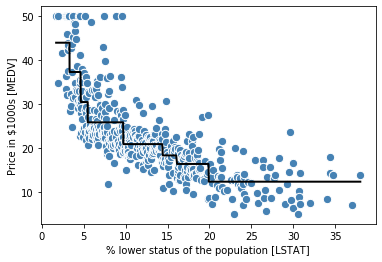

In [6]:
tree = DecisionTreeRegressor(max_depth=3)
tree.fit(X, y)

sort_idx = X.flatten().argsort()

lin_regplot(X[sort_idx], y[sort_idx], tree)
plt.xlabel('% lower status of the population [LSTAT]')
plt.ylabel('Price in $1000s [MEDV]')
#plt.savefig('images/10_13.png', dpi=300)
plt.show()

從這張圖可以看出，決策數能描述數據的整體趨勢，卻無法描述連續性與可微性。因此我們必須小心選擇深度，使之不要overfitting或underfitting。
接著我們來看隨機森林回歸法，首先先分割訓練集與數據集

In [7]:
X = df.iloc[:, :-1].values
y = df['MEDV'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)

呼叫scikit learn的隨機森林回歸器，並分別計算測試集與訓練集的MSE與$R^2$。

In [8]:
forest = RandomForestRegressor(n_estimators=1000, 
                               criterion='mse', 
                               random_state=1, 
                               n_jobs=-1)
forest.fit(X_train, y_train)
y_train_pred = forest.predict(X_train)
y_test_pred = forest.predict(X_test)

print('MSE train: %.3f, test: %.3f' % (
        mean_squared_error(y_train, y_train_pred),
        mean_squared_error(y_test, y_test_pred)))
print('R^2 train: %.3f, test: %.3f' % (
        r2_score(y_train, y_train_pred),
        r2_score(y_test, y_test_pred)))

MSE train: 1.641, test: 11.056
R^2 train: 0.979, test: 0.878


可以發現對訓練集與測試集的正確率相差太多，這代表發生了overfitting。為了更深入理解原因，我們繪製殘差圖。

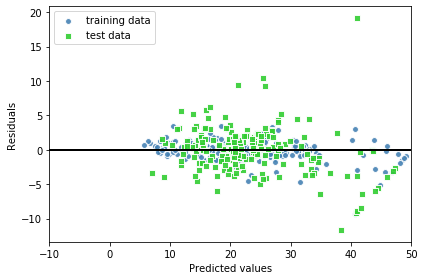

In [9]:
plt.scatter(y_train_pred,  
            y_train_pred - y_train, 
            c='steelblue',
            edgecolor='white',
            marker='o', 
            s=35,
            alpha=0.9,
            label='training data')
plt.scatter(y_test_pred,  
            y_test_pred - y_test, 
            c='limegreen',
            edgecolor='white',
            marker='s', 
            s=35,
            alpha=0.9,
            label='test data')

plt.xlabel('Predicted values')
plt.ylabel('Residuals')
plt.legend(loc='upper left')
plt.hlines(y=0, xmin=-10, xmax=50, lw=2, color='black')
plt.xlim([-10, 50])
plt.tight_layout()

# plt.savefig('images/10_14.png', dpi=300)
plt.show()

理想情況下模型的錯誤是隨機而不可預測的。如果我們檢查殘差圖發現了某種顯而易見的模式，就代表有一些具有意義的資訊流到殘差之中造成模型的錯誤，需重新調教。\\
非常不幸的是，如果看不出來殘差圖的模式，並不代表沒有資訊流到殘差之中。更慘的是，數學家與資料科學家對此束手無策，無法處理或判斷錯誤的隨機性。對此的建議通常是：
1. 對變量做一些變換
2. 調整學習演算法的超參數
3. 選擇更簡單或更複雜的模型
4. 移除離群值
5. 選用其他變量